# **Kategori Kesehatan**

### **Problem Understanding**

1.   Latar Belakang Masalah

        Penyakit tidak menular seperti penyakit jantung, diabetes, dan hipertensi menjadi penyebab utama masalah kesehatan di masyarakat modern. Biaya penanganan yang tinggi dan penurunan kualitas hidup menuntut adanya pendekatan preventif. Deteksi dini melalui pemahaman terhadap faktor-faktor risiko menjadi kunci untuk merancang program kesehatan yang efektif dan tepat sasaran. Analisis data rekam medis pasien dapat mengungkap pola tersembunyi yang krusial bagi upaya pencegahan ini

---

2.   Rumusan Masalah

        Sebuah institusi kesehatan ingin mengembangkan program deteksi dini yang lebih efektif, namun belum memiliki pemahaman mendalam tentang faktor mana yang paling signifikan berkontribusi terhadap diagnosa penyakit jantung, diabetes, dan hipertensi pada populasi pasien mereka.

---

3.   Pertanyaan Analitis Kunci
        
        Untuk memecahkan masalah tersebut, analisis ini akan menjawab pertanyaan berikut:

        *   Demografi: Bagaimana distribusi usia dan jenis kelamin pada pasien yang terdiagnosis penyakit jantung, diabetes, dan hipertensi?
        *   Faktor Gaya Hidup: Apakah ada korelasi yang kuat antara status merokok dan tingkat aktivitas fisik dengan diagnosa penyakit-penyakit tersebut?
        *   Indikator Medis: Seberapa besar pengaruh tingkat kolesterol dan riwayat penyakit keluarga terhadap kemungkinan seseorang terdiagnosis penyakit tertentu?

---

4.   Metrik Keberhasilan

      Analisis ini dianggap berhasil jika mampu menghasilkan minimal 2-3 rekomendasi strategis yang dapat ditindaklanjuti (contoh: segmentasi pasien prioritas untuk program screening) yang berpotensi meningkatkan efektivitas program kesehatan preventif.

### **Data Processing & Preprocessing**

Kita akan melakukan beberapa tindakan pembersihan kunci:

*   Standardisasi Nilai: Menyamakan data kategorikal yang memiliki makna sama tapi format berbeda (misal: "Laki-laki" & "Pria").
*   Mengatasi Nilai Kosong: Mengisi data yang hilang (NaN) menggunakan metode statistik yang sesuai.
*   Memperbaiki Tipe Data: Mengonversi kolom tanggal yang masih berupa teks menjadi format tanggal (datetime).



In [ ]:
# import module yang akan digunakan
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
# import data menjadi pandas DataFrame
df = pd.read_csv("kesehatan.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'kesehatan.csv'

In [ ]:
# tinjau data (head)
df.head()

In [ ]:
# samakan format string (lowercase without leading/trailing space)
df = df.apply(lambda col: col.str.strip().str.lower() if col.dtype == "object" else col)

# tinjau banyaknya value unique dan banyaknya missing value di setiap kolom
summary = pd.DataFrame({
    "Unique Values" : df.nunique(),
    "Missing Values" : df.isnull().sum(),
    "Data Types" : df.dtypes
})
summary

In [ ]:
df["Diagnosa_Penyakit"].unique()

In [ ]:
# ENCODING

# Ubah tipe data "Jenis_Kelamin" menjadi boolean (1 = Laki-laki, 0 = Perempuan), untuk mempermudah pemrosesan
df["Jenis_Kelamin"] = df["Jenis_Kelamin"].str.strip().str.lower()
df["Jenis_Kelamin"] = df["Jenis_Kelamin"].map({
    "pria": 1,
    "laki-laki": 1,
    "perempuan": 0
})

# Ubah tipe data "Diabetes" menjadi integer (One-Hot)
df["Diabetes"] = df["Diabetes"].map({
    "ya" : 1,
    "tidak" : 0
})

# Ubah tipe data "Cholesterol" menjadi integer
df["Cholesterol"] = df["Cholesterol"].map({
    "rendah" : 1,
    "normal" : 2,
    "tinggi" : 3
})

# Ubah tipe data "Aktifitas_Fisik" menjadi integer
df["Aktifitas_Fisik"] = df["Aktifitas_Fisik"].map({
    "rendah" : 1,
    "sedang" : 2,
    "tinggi" : 3
})

# Ubah tipe data "Merokok" menjadi numerik (One-Hot)
df["Merokok"] = df["Merokok"].map({
    "ya" : 1,
    "tidak" : 0
})

# Ubah tipe data "Riwayat_Penyakit_Keluarga" menjadi integer(One-Hot)
df["Riwayat_Penyakit_Keluarga"] = df["Riwayat_Penyakit_Keluarga"].map({
    "ya" : 1,
    "tidak" : 0
})

# Konversi "Tanggal_Pemeriksaan" menjadi format DateTime
df["Tanggal_Pemeriksaan"] = df["Tanggal_Pemeriksaan"].astype(str).str.strip()
parsed_dash = pd.to_datetime(df["Tanggal_Pemeriksaan"], format="%Y-%m-%d", errors="coerce")
parsed_slash = pd.to_datetime(df["Tanggal_Pemeriksaan"], format="%Y/%m/%d", errors="coerce")
df["Tanggal_Pemeriksaan"] = parsed_dash.fillna(parsed_slash)

In [ ]:
# --- FEATURE ENGINEERING TEKANAN DARAH ---
# Membuat fitur baru dari data yang ada

# Konversi "Tekanan_Darah" menjadi (Label)
df[["systolic", "diastolic"]] = df["Tekanan_Darah"].str.split("/", expand=True).astype(int)
# Mendefinisikan fungsi untuk mengkategorikan tekanan darah
def categorize_bp(row):
    sys, dia = row["systolic"], row["diastolic"]

    if sys > 180 or dia > 120:
        return 5
    elif sys >= 140 or dia >= 90:
        return 4
    elif 130 <= sys <= 139 or 80 <= dia <= 89:
        return 3
    elif 120 <= sys <= 129 and dia < 80:
        return 2
    elif sys < 120 and dia < 80:
        return 1
    else:
        return 0

df["Tekanan_Darah"] = df.apply(categorize_bp, axis=1)
df = df.drop(columns=["systolic", "diastolic"])


AKTIFITAS_FISIK distribution before vs after imputation:
Before (non-missing only):
Aktifitas_Fisik
0    0.805
1    0.195
Name: proportion, dtype: float64
After (all rows):
Aktifitas_Fisik
0    0.805
1    0.195
Name: proportion, dtype: float64


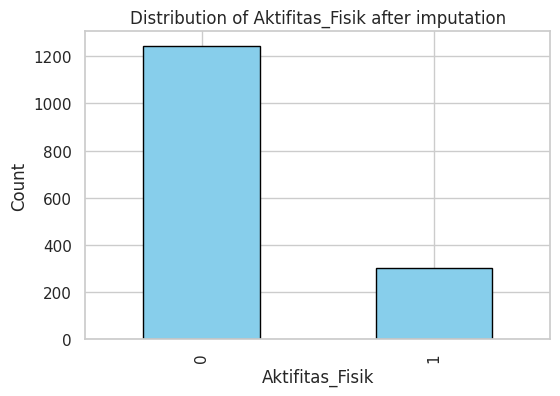


MEROKOK distribution before vs after imputation:
Before (non-missing only):
Merokok
0    0.702
1    0.298
Name: proportion, dtype: float64
After (all rows):
Merokok
0    0.702
1    0.298
Name: proportion, dtype: float64


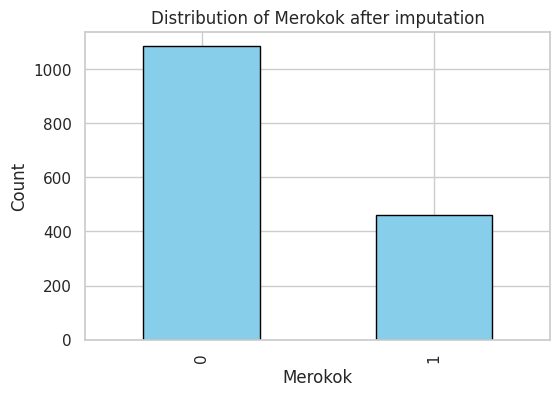

In [ ]:
# -- Handling Missing Value --
# Mengisi nilai yang kosong menggunakan metode K-Nearest Neighbors (KNN)

# Memilih fitur-fitur numerik yang akan digunakan untuk imputasi
features = [
    "Jenis_Kelamin", "Usia", "Tinggi_cm", "Berat_kg",
    "Tekanan_Darah", "Diabetes", "Cholesterol", "Riwayat_Penyakit_Keluarga",
    "Aktifitas_Fisik", "Merokok"
]

# Membuat subset DataFrame hanya dengan fitur yang dipilih
df_subset = df[features]

# Membuat pipeline untuk proses imputasi
pipeline = Pipeline([
    ("scaler", StandardScaler()), # Langkah 1: Menstandarkan data (mean=0, std=1)
    ("imputer", KNNImputer(n_neighbors=5)) # Langkah 2: Mengisi nilai hilang berdasarkan 5 tetangga terdekat
])

df_imputed = pipeline.fit_transform(df_subset)
df_imputed = pd.DataFrame(df_imputed, columns=features)

binary_cols = ["Jenis_Kelamin", "Diabetes", "Riwayat_Penyakit_Keluarga", "Aktifitas_Fisik", "Merokok"]

df_imputed[binary_cols] = df_imputed[binary_cols].round()
# Mengubah hasil imputasi (array numpy) kembali menjadi DataFrame pandas
df_imputed[binary_cols] = df_imputed[binary_cols].clip(0, 1).astype(int)

# Menentukan kolom-kolom yang seharusnya bernilai biner (0 atau 1)
df[["Aktifitas_Fisik", "Merokok"]] = df_imputed[["Aktifitas_Fisik", "Merokok"]]

def plot_distribution(col):
    plt.figure(figsize=(6,4))
    df[col].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(f"Distribution of {col} after imputation")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Loop untuk membandingkan distribusi sebelum dan sesudah imputasi
for col in ["Aktifitas_Fisik", "Merokok"]:
    print(f"\n{col.upper()} distribution before vs after imputation:")

    print("Before (non-missing only):")
    print(df_subset[col].value_counts(dropna=True, normalize=True).round(3))

    print("After (all rows):")
    print(df[col].value_counts(normalize=True).round(3))

    plot_distribution(col)

### **Exploratory Data Analysis**



#### **1.   Analisis Univariate (Melihat Distribusi per Variabel)**

        Kita perlu tahu karakteristik dasar dari pasien kita.

      *   Pertanyaan: Bagaimana distribusi usia pasien dan diagnosa penyakit yang paling umum?
      *   Metode: Histogram untuk melihat sebaran data numerik (Usia) dan Bar Chart untuk menghitung frekuensi data kategorikal (Diagnosa Penyakit).

Dari grafik di atas, kita bisa melihat bahwa mayoritas pasien berada di rentang usia 40-80 tahun dan diagnosa paling umum adalah "Sehat", diikuti oleh "Hipertensi" dan "Penyakit Jantung".


#### **2.   Analisis Bivariate (Melihat Hubungan Antar Variabel)**

      Sekarang kita cari hubungan antar faktor.

      *   Pertanyaan: Apakah ada hubungan antara status merokok dengan penyakit jantung?
      *   Metode: Grouped Bar Chart untuk membandingkan proporsi dua variabel kategorikal.

Visualisasi ini menunjukkan perbandingan jumlah perokok dan non-perokok untuk setiap penyakit utama. Ini adalah insight awal yang sangat bagus untuk dimasukkan ke dalam presentasi Anda.

---

Visualisasi ini memberikan gambaran awal yang kuat. Untuk melihat hubungan antar semua variabel numerik (Usia, Tinggi, Berat, Tekanan Darah) sekaligus, langkah selanjutnya yang sangat efektif adalah membuat heatmap korelasi. Ini akan menjadi visualisasi yang sangat padat informasi untuk presentasi Anda.

#### **3. Analisis Multivariat (Melihat Korelasi Antar Variabel Numerik)**

Sebelum membuat heatmap, kita perlu melakukan satu langkah preprocessing penting: memisahkan kolom Tekanan_Darah (yang formatnya "121/74") menjadi dua kolom numerik terpisah: Sistolik (angka atas) dan Diastolik (angka bawah).

*   Pertanyaan: Variabel numerik mana yang memiliki korelasi (hubungan) paling kuat satu sama lain?
*   Metode: Heatmap Korelasi. Peta panas ini akan menunjukkan nilai korelasi dari -1 (korelasi negatif sempurna) hingga +1 (korelasi positif sempurna). Semakin mendekati 1 atau -1, semakin kuat hubungannya.



In [ ]:
# Basic EDA / Profiling
from ydata_profiling import ProfileReport
import pandas as pd
from IPython.core.display import display, HTML


profile = ProfileReport(
    df,
    title="Laporan EDA Kesehatan",
    explorative=True,
    correlations={"pearson": {"calculate": True}},
    missing_diagrams={"heatmap": True, "dendrogram": True}
)

profile.to_file("laporan_eda.html")

with open("laporan_eda.html", "r", encoding="utf-8") as f:
    html_content = f.read()

display(HTML(html_content))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 41.01it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

[link text](https://)### **Visualisasi dan Hasil Rekomendasi**

#### **Ringkasan Temuan (Insight)**

Dari analisis eksploratif (EDA) yang telah kita lakukan, kita menemukan beberapa pola kunci:

1.   Distribusi Penyakit: Diagnosa non-sehat yang paling umum diderita oleh pasien dalam dataset ini adalah Hipertensi, diikuti oleh Penyakit Jantung dan Diabetes.
2.   Kelompok Usia Rentan: Pasien yang terdiagnosis penyakit-penyakit tersebut mayoritas berada pada rentang usia paruh baya hingga lansia (40 tahun ke atas), seperti yang ditunjukkan oleh grafik distribusi usia.
3.   Faktor Gaya Hidup: Walaupun tidak semua pasien penyakit jantung adalah perokok, namun pada kelompok Penyakit Jantung, jumlah pasien yang merokok (Ya) terlihat signifikan dibandingkan kelompok penyakit lain.
4.   Korelasi Fisik: Terdapat korelasi positif yang wajar antara tinggi dan berat badan, namun tidak ada korelasi langsung yang sangat kuat antara usia dengan tekanan darah dari data yang ada.

#### **Visualisasi Rekomendasi**

Untuk mempertajam rekomendasi, kita perlu satu visualisasi kunci yang membandingkan faktor risiko medis (seperti kolesterol) terhadap diagnosa penyakit.

*   Tujuan Visualisasi: Memperlihatkan bagaimana tingkat kolesterol terdistribusi pada pasien dengan diagnosa penyakit yang berbeda.
*   Metode: Violin Plot, karena dapat menunjukkan distribusi (seperti histogram) dan rentang (seperti box plot) secara bersamaan, sangat efektif untuk perbandingan.

#### **Hasil Rekomendasi**
Berdasarkan temuan dan visualisasi di atas, berikut adalah 3 rekomendasi strategis yang bisa diajukan:

1.  Rekomendasi 1: Prioritaskan Skrining Hipertensi untuk Usia 40+.

    *  Alasan: Data menunjukkan Hipertensi adalah kondisi paling umum kedua setelah "Sehat", dengan konsentrasi pasien di usia paruh baya ke atas.

    *  Tindakan: Mengadakan program pemeriksaan tekanan darah gratis atau bersubsidi yang secara proaktif menargetkan populasi berusia di atas 40 tahun.

2.  Rekomendasi 2: Kampanye Anti-Merokok dengan Fokus Risiko Penyakit Jantung.

    *  Alasan: Visualisasi kami menunjukkan adanya asosiasi antara status merokok dengan diagnosa Penyakit Jantung.

    *  Tindakan: Membuat materi kampanye yang secara spesifik menampilkan testimoni atau data visual hubungan merokok dengan risiko penyakit jantung, bukan hanya penyakit pernapasan.

3.  Rekomendasi 3: Edukasi Kolesterol sebagai Faktor Risiko Lintas-Penyakit.

    *  Alasan: Violin plot menunjukkan bahwa pasien dengan diagnosa Penyakit Jantung, Hipertensi, dan Diabetes cenderung memiliki distribusi kolesterol pada level 'tinggi'.

    *  Tindakan: Mengembangkan program edukasi "Kenali Kolesterolmu" yang tidak hanya ditujukan untuk mencegah kolesterol tinggi, tetapi juga sebagai bagian dari manajemen risiko bagi penderita hipertensi dan diabetes.


In [4]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df['is_merokok'] = (df['Merokok'] == 1)
df['is_physical'] = (df['Aktifitas_Fisik'] == 1)
df['is_diabetes'] = (df['Diagnosa_Penyakit'] == 'diabetes')
df['is_hipertensi'] = (df['Diagnosa_Penyakit'] == 'hipertensi')
df['is_kolesterol'] = (df['Diagnosa_Penyakit'] == 'kolesterol tinggi')

memberships = []
for idx, row in df.iterrows():
    active = []
    if row['is_merokok']: active.append("Merokok")
    if row['is_diabetes']: active.append("Diabetes")
    if row['is_hipertensi']: active.append("Hipertensi")
    if row['is_kolesterol']: active.append("Kolesterol Tinggi")
    if row['is_physical']: active.append("Berolahraga")
    memberships.append(active)

data = from_memberships(memberships)

up = UpSet(data, subset_size='count', show_counts=True)
up.plot()
plt.suptitle("UpSet Plot: Interseksi Faktor Risiko")
plt.show()


ModuleNotFoundError: No module named 'upsetplot'